# Trying to to release particles on several days --> timeps


In [1]:
#%matplotlib inline
from parcels import Field, FieldSet, ParticleSet, JITParticle,  AdvectionRK4, ErrorCode, DiffusionUniformKh
import numpy as np
from datetime import timedelta, datetime
import xarray as xr

import pytz
from netCDF4 import num2date, date2num

In [2]:
import sys

sys.path.insert(0, "/storage/home/gomez023/WOC_ESA/")

from add_WOC_nc_attbts_v02 import *

In [3]:
data_path_v02 = '/storage/shared/oceanparcels/output_data/data_LauraGN/WOC/v02_current_data/separate_componets/ATL/Sep2011/'
fname_v02 = 'runconv15m_enatl2_d*.nc'

# --> trying then with not the 24 hrs just 00h:

In [4]:
timestamps_all = np.expand_dims(np.array([np.datetime64('2011-09-%.2d 00:00:00' %d) for d in range(1,31)]), axis=1)
#     timestamps_all = np.vstack((timestamps_all,timestamps))
timestamps_all

array([['2011-09-01T00:00:00'],
       ['2011-09-02T00:00:00'],
       ['2011-09-03T00:00:00'],
       ['2011-09-04T00:00:00'],
       ['2011-09-05T00:00:00'],
       ['2011-09-06T00:00:00'],
       ['2011-09-07T00:00:00'],
       ['2011-09-08T00:00:00'],
       ['2011-09-09T00:00:00'],
       ['2011-09-10T00:00:00'],
       ['2011-09-11T00:00:00'],
       ['2011-09-12T00:00:00'],
       ['2011-09-13T00:00:00'],
       ['2011-09-14T00:00:00'],
       ['2011-09-15T00:00:00'],
       ['2011-09-16T00:00:00'],
       ['2011-09-17T00:00:00'],
       ['2011-09-18T00:00:00'],
       ['2011-09-19T00:00:00'],
       ['2011-09-20T00:00:00'],
       ['2011-09-21T00:00:00'],
       ['2011-09-22T00:00:00'],
       ['2011-09-23T00:00:00'],
       ['2011-09-24T00:00:00'],
       ['2011-09-25T00:00:00'],
       ['2011-09-26T00:00:00'],
       ['2011-09-27T00:00:00'],
       ['2011-09-28T00:00:00'],
       ['2011-09-29T00:00:00'],
       ['2011-09-30T00:00:00']], dtype='datetime64[s]')

In [5]:
filenames = {'U': data_path_v02 + fname_v02, 'V': data_path_v02 + fname_v02}
variables = {'U': 'UG_CMEMS', 'V': 'VG_CMEMS'}
dimensions = {'U': {'lat': 'lat', 'lon': 'lon', 'time': 'time'},
              'V': {'lat': 'lat', 'lon': 'lon', 'time': 'time'}} #, 'depth': 'depth'
#indices = {'depth': [0]} # choosing 00m depth
fieldset_UG_CMEMS = FieldSet.from_netcdf(filenames, variables, dimensions, timestamps=timestamps_all)


In [6]:
filenames = {'U': data_path_v02 + fname_v02, 'V': data_path_v02 + fname_v02}
variables = {'U': 'U', 'V': 'V'}
dimensions = {'U': {'lat': 'lat', 'lon': 'lon', 'time': 'time'},
              'V': {'lat': 'lat', 'lon': 'lon', 'time': 'time'}} #, 'depth': 'depth'
#indices = {'depth': [0]} # choosing 00m depth
fieldset_Uageos = FieldSet.from_netcdf(filenames, variables, dimensions, timestamps=timestamps_all)


In [8]:
# print(pset_v2.particle_data['time'][0]) 

In [9]:
fieldset_UG_CMEMS.time_origin

2011-09-01T00:00:00

In [7]:
fieldset_total = FieldSet(U=fieldset_UG_CMEMS.U + fieldset_Uageos.U, V=fieldset_UG_CMEMS.V + fieldset_Uageos.V)


# Particle release:

In [8]:
# Oil release location approx:
# 55.768N, 7.66E
ref_lat = 55.768
lon_ref = 7.66

# --> we do mesh (min lon to max lon 13km, so more than first rossby radius to take into account structures present not exactly on at same position!)

lons_list=[7.60, 7.62, 7.64, lon_ref, 7.68, 7.70, 7.72]
lats_list=[ref_lat-.06, ref_lat-.04, ref_lat-.02, ref_lat, ref_lat+.02, ref_lat+.04, ref_lat+.06]

In [9]:
# step = .25 # degrees
# lons, lats = np.meshgrid(np.arange(125., 126.+step, step), np.arange(28, 29+step, step))
lons, lats = np.meshgrid(np.array(lons_list), np.array(lats_list))

lons.shape[0]*lons.shape[1]

49

In [10]:
timep = datetime(2011,9,10)

In [11]:
from datetime import timedelta as delta

repeatdt = delta(hours=1.)  # release from the same set of locations every 1 hour


In [14]:
def DeleteParticle(particle, fieldset, time):
    particle.delete()

## 2.4. Particle Set:

In [12]:
pset_v2 = ParticleSet(fieldset=fieldset_total, pclass=JITParticle, lon=lons, lat=lats, time=timep, repeatdt=repeatdt) #, depth=depp


# 3. Executing the simulation:

## 3.1. Defining parameters

In [5]:
file_name = "test03_v02_ATL_Sep2011_cont1h_MESH.nc"

In [6]:
output_file = pset_v2.ParticleFile(name=file_name, outputdt=timedelta(hours=1))

NameError: name 'pset_v2' is not defined

## 3.2. Running

In [16]:
pset_v2.execute(pset_v2.Kernel(AdvectionRK4), runtime=timedelta(days=14.), dt=timedelta(minutes=10),
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle}, output_file=output_file)

start_time = timep.isoformat()
time_unit_out= "seconds since " + str(pset_v2.time_origin)
end_time = (num2date(output_file.lasttime_written, time_unit_out)).isoformat()

add_WOC_nc_attbts(output_file, start_time, end_time, -75.0, 20., 48., 80.
        , input_filename="WOC-L4-CUReul-ENATL-1H: runconv15m_enatl2_d*.nc'"
        , ntitle="North Atlantic 2D horizontal drift of Oil spill for ESA WOC project" 
        , summary="This dataset contains the positions of virtual particles released hourly from 10/09/2011 to 25/09/2011 at 15m representing the trajectories of an oil spill event in the North Atlantic."
        , inid = "NATL_OIL_SPILL_DRIFT_1H_CONT"
        , ndepth = "15")

output_file.export()  # exports the trajectory data to a netcdf file



sh: None: command not found
INFO: Compiled ArrayJITParticleAdvectionRK4 ==> /tmp/parcels-319202/libffc08dab85b61f54499aa460abcfb7ed_0.so
INFO: Temporary output files are stored in out-UFHBJABM.
INFO: You can use "parcels_convert_npydir_to_netcdf out-UFHBJABM" to convert these to a NetCDF file during the run.
100% (1209600.0 of 1209600.0) |##########| Elapsed Time: 0:00:06 Time:  0:00:06
/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


```
pset_v2.execute(pset_v2.Kernel(AdvectionRK4), runtime=timedelta(days=14.), dt=timedelta(minutes=10),
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle}, output_file=output_file)

start_time = timep.isoformat()
# Check in case it's not NaN:
# print(pset_v2.particle_data['time'][0]) #modify to assert 
time_unit_out= "seconds since " + str(pset_v2.time_origin)
# end_time = (num2date(pset_v2.particle_data['time'][0], time_unit_out)).isoformat()
end_time = (num2date(output_file.lasttime_written, time_unit_out)).isoformat()

add_WOC_nc_attbts(output_file, start_time, end_time, -75.0, 20., 48., 80.
        , input_filename="WOC-L4-CUReul-ENATL-1H: runconv15m_enatl2_d*.nc'"
        , ntitle="North Atlantic 2D horizontal drift of Oil spill for ESA WOC project" 
        , summary="This dataset contains the positions of virtual particles released hourly from 10/09/2011 to 25/09/2011 at 15m representing the trajectories of an oil spill event in the North Atlantic."
        , inid = "NATL_OIL_SPILL_DRIFT_1H_CONT"
        , ndepth = "15")

output_file.export()  # exports the trajectory data to a netcdf file
```


In [17]:
!ls -trl 

total 4876916
-rw-r--r-- 1 gomez023 U_UPG_Gomez023_P     757012 May  6 17:23 2022-04-04-parcels_15m_inst_NATL_v02.ipynb
-rw-r--r-- 1 gomez023 U_UPG_Gomez023_P   22269477 May  6 17:29 test01_v02_ATL_Sep2011_cont1h_MESH_02.nc
-rw-r--r-- 1 gomez023 U_UPG_Gomez023_P      45330 May  6 18:33 2022-05-05_formatting_ATL_15m.ipynb
-rw-r--r-- 1 gomez023 U_UPG_Gomez023_P  155834678 May  6 18:53 test02_v02_ATL_Sep2011_cont1h_MESH.nc
-rw-r--r-- 1 gomez023 U_UPG_Gomez023_P  155834678 May  8 14:40 test01_v02_ATL_Sep2011_cont1h_MESH_TOTAL.nc
-rw-r--r-- 1 gomez023 U_UPG_Gomez023_P     475801 May  8 16:53 2022-04-05-parcels_15m_inst_NATL_v02_03_TOTAL_vel.ipynb
-rw-r--r-- 1 gomez023 U_UPG_Gomez023_P  155834678 May  8 17:07 test02_v02_ATL_Sep2011_cont1h_MESH_TOTAL.nc
-rw-r--r-- 1 gomez023 U_UPG_Gomez023_P     707874 May  8 17:36 2022-04-04-parcels_15m_inst_NATL_v02_02.ipynb
-rw-r--r-- 1 gomez023 U_UPG_Gomez023_P     187070 May  8 17:45 2022-04-06-parcels_15m_inst_NATL_v02_winds_002_test01.ipynb
-rw-r--r-- 

In [18]:
!ncdump -h test03_v02_ATL_Sep2011_cont1h_MESH.nc


netcdf test03_v02_ATL_Sep2011_cont1h_MESH {
dimensions:
	obs = 337 ;
	traj = 16513 ;
variables:
	int64 trajectory(traj, obs) ;
		trajectory:_FillValue = -9223372036854775808LL ;
		trajectory:long_name = "Unique identifier for each particle" ;
		trajectory:cf_role = "trajectory_id" ;
	double time(traj, obs) ;
		time:_FillValue = NaN ;
		time:long_name = "" ;
		time:standard_name = "time" ;
		time:units = "seconds since 2011-09-01T00:00:00" ;
		time:calendar = "standard" ;
		time:axis = "T" ;
	float lat(traj, obs) ;
		lat:_FillValue = NaNf ;
		lat:long_name = "" ;
		lat:standard_name = "latitude" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
	float lon(traj, obs) ;
		lon:_FillValue = NaNf ;
		lon:long_name = "" ;
		lon:standard_name = "longitude" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
	float z(traj, obs) ;
		z:_FillValue = NaNf ;
		z:long_name = "" ;
		z:standard_name = "depth" ;
		z:units = "m" ;
		z:positive = "down" ;

// global attributes:
		:feature_type = "traje

In [7]:
from datetime import timedelta, datetime
from glob import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import colors 

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [8]:
ds = xr.open_dataset('test03_v02_ATL_Sep2011_cont1h_MESH.nc')

In [9]:
ds


<xarray.Dataset>
Dimensions:     (traj: 16513, obs: 337)
Dimensions without coordinates: traj, obs
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float32 ...
    lon         (traj, obs) float32 ...
    z           (traj, obs) float32 ...
Attributes: (12/57)
    feature_type:                  trajectory
    Conventions:                   CF-1.7, ACDD-1.3, ISO 8601
    ncei_template_version:         NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:               2.3.1.dev20+g92f2fb90
    parcels_mesh:                  spherical
    Metadata_Conventions:          Climate and Forecast (CF) 1.7, Attribute C...
    ...                            ...
    date_modified:                 2022-05-06T12:23:53
    source:                        parcels
    source_version:                2.3.1.dev20+g92f2fb90
    history:                       2022-05-06T12:23:53 - Creation
    input:                         WOC-L4-CUReul-ENATL-1H: runconv15m_enatl2_...
    processing_software:           parcels

In [10]:
49*14*24

16464

/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


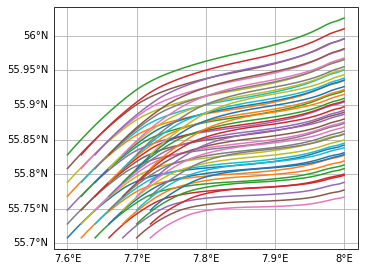

In [11]:
plt.figure(figsize=(12,10)) #(17,5)

ax1 = plt.subplot(121, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.plot(ds['lon'][0:49,:].T, ds['lat'][0:49,:].T, transform=ccrs.PlateCarree()) #marker='o'
# ax1.set_xlim([6, 12])
# ax1.set_ylim([52, 59])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


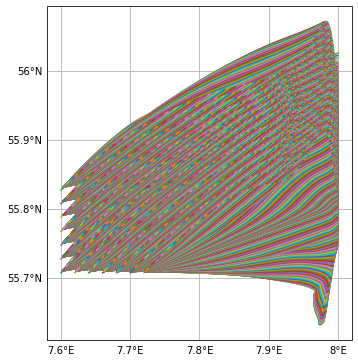

In [11]:
plt.figure(figsize=(12,10)) #(17,5)

ax1 = plt.subplot(121, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.plot(ds['lon'].T, ds['lat'].T, transform=ccrs.PlateCarree()) #marker='o'
# ax1.set_xlim([6, 12])
# ax1.set_ylim([52, 59])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

In [12]:
ds.time[0,:]

<xarray.DataArray 'time' (obs: 337)>
array(['2011-09-10T00:00:00.000000000', '2011-09-10T01:00:00.000000000',
       '2011-09-10T02:00:00.000000000', ..., '2011-09-23T22:00:00.000000000',
       '2011-09-23T23:00:00.000000000', '2011-09-24T00:00:00.000000000'],
      dtype='datetime64[ns]')
Dimensions without coordinates: obs
Attributes:
    long_name:      
    standard_name:  time
    axis:           T

In [25]:
14*24

336

In [26]:
337*49

16513

/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


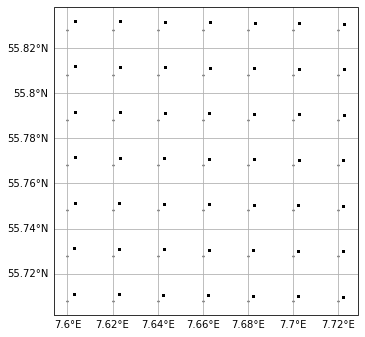

In [27]:
plt.figure(figsize=(12,10)) #(17,5)

ax1 = plt.subplot(121, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.scatter(ds['lon'][:,0], ds['lat'][:,0], c='k', s=1, transform=ccrs.PlateCarree(), label = 'Simulation release positions') #marker='o'
# ax1.set_xlim([6, 12])
# ax1.set_ylim([52, 59])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# --> looks good!

/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


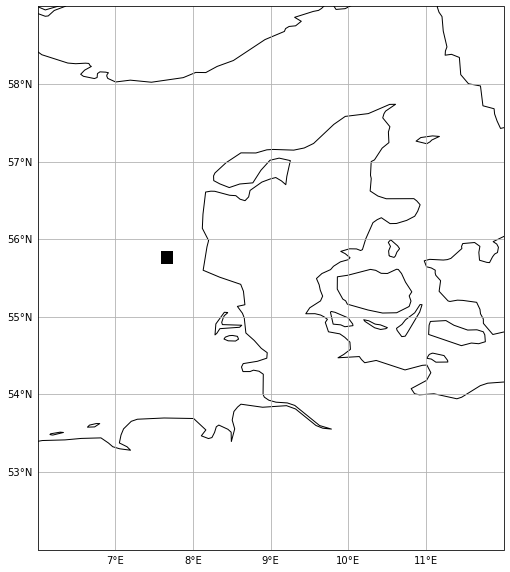

In [13]:
plt.figure(figsize=(12,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.scatter(ds['lon'][:,0], ds['lat'][:,0], c='k', s=1, transform=ccrs.PlateCarree(), label = 'Simulation release positions') #marker='o'
ax1.set_xlim([6, 12])
ax1.set_ylim([52, 59])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


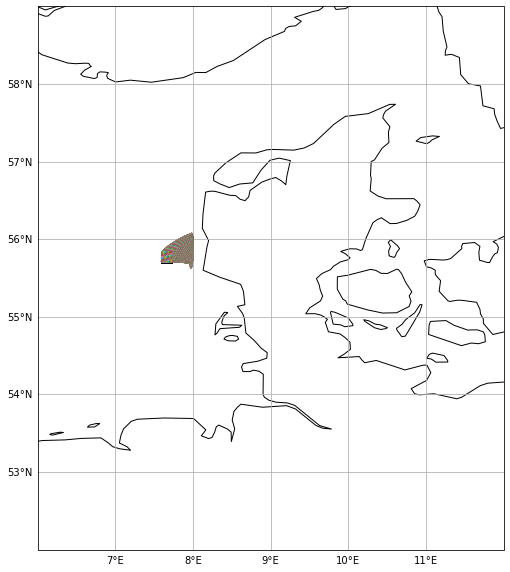

In [14]:
plt.figure(figsize=(12,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.plot(ds['lon'].T, ds['lat'].T, transform=ccrs.PlateCarree()) #marker='o'
ax1.scatter(ds['lon'][:,0], ds['lat'][:,0], c='k', s=1, transform=ccrs.PlateCarree(), label = 'Simulation release positions') #marker='o'
ax1.set_xlim([6, 12])
ax1.set_ylim([52, 59])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


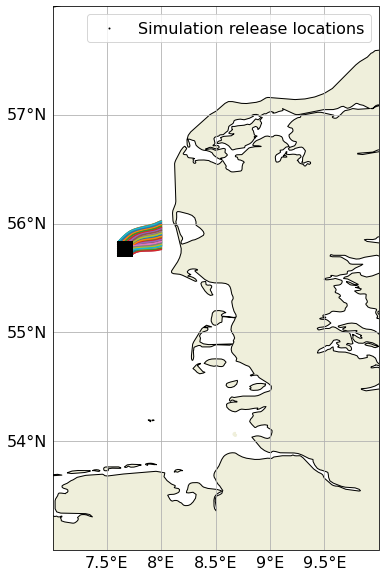

In [23]:
plt.figure(figsize=(12,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='10m')
ax1.add_feature(cartopy.feature.LAND, facecolor=cartopy.feature.COLORS['land'])

ax1.plot(ds['lon'][0:200,:].T, ds['lat'][0:200,:].T, transform=ccrs.PlateCarree()) #marker='o'
ax1.scatter(ds['lon'][:,0], ds['lat'][:,0], c='k', s=1, transform=ccrs.PlateCarree(), label = 'Simulation release locations', zorder=500) #marker='o'
ax1.set_xlim([7, 10])
ax1.set_ylim([53, 58])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16} #, 'color': 'gray'}
gl.ylabel_style = {'size': 16} #{'color': 'red', 'weight': 'bold'}
ax1.legend(fontsize=16)

plt.savefig('OilSpills_NATL_v2_01.png', dpi=300)


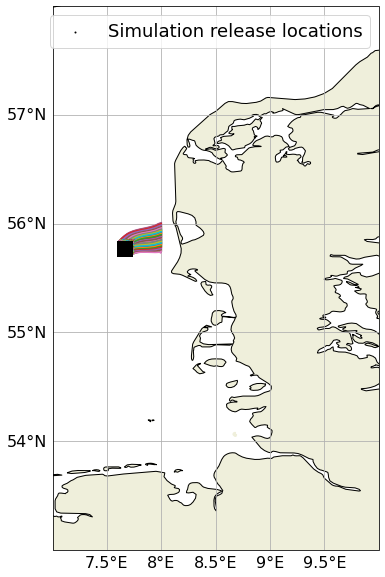

In [22]:
plt.figure(figsize=(12,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='10m')
ax1.add_feature(cartopy.feature.LAND, facecolor=cartopy.feature.COLORS['land'])

ax1.plot(ds['lon'][300:500,:].T, ds['lat'][300:500,:].T, transform=ccrs.PlateCarree()) #marker='o'
ax1.plot(ds['lon'][-300::,:].T, ds['lat'][-300::,:].T, transform=ccrs.PlateCarree()) #marker='o'
ax1.scatter(ds['lon'][:,0], ds['lat'][:,0], c='k', s=1, transform=ccrs.PlateCarree(), label = 'Simulation release locations', zorder=500) #marker='o'
ax1.set_xlim([7, 10])
ax1.set_ylim([53, 58])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16} #, 'color': 'gray'}
gl.ylabel_style = {'size': 16} #{'color': 'red', 'weight': 'bold'}
ax1.legend(fontsize=18)

# plt.savefig('OilSpills_NATL_v2_01.png', dpi=300)


# --> does not change much if I plot less particles!

# --> tides, wind , stokes, coastal current?

# Comparing with v01:

In [12]:
outdir =  "/storage/shared/oceanparcels/output_data/data_LauraGN/WOC/Oil/v01/"

ds_15_v01 = xr.open_dataset(outdir + "Lorenz_20110910000000-WOC-L4-CURlag-NATL_oil_spill_drift_1H_15m_instantaneous-v1.0-fv1.0.nc")


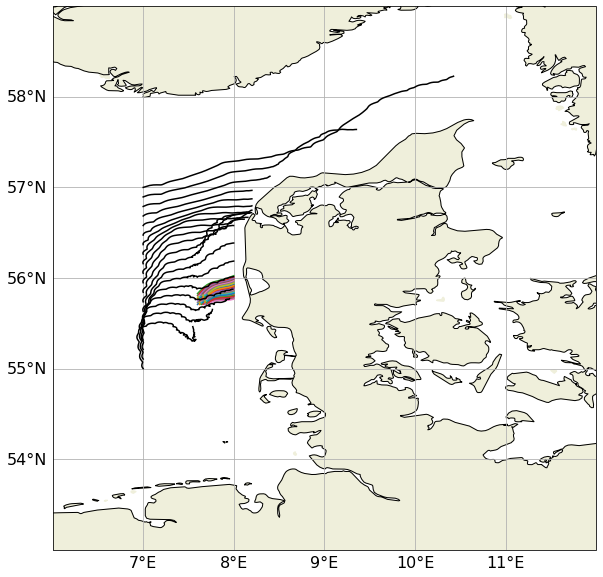

In [18]:
plt.figure(figsize=(12,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='10m')
ax1.add_feature(cartopy.feature.LAND, facecolor=cartopy.feature.COLORS['land'])
ax1.plot(ds['lon'][0:49,:].T, ds['lat'][0:49,:].T, transform=ccrs.PlateCarree())#, label='Version 2') #marker='o'
# ax1.scatter(ds['lon'][:,0], ds['lat'][:,0], c='k', s=1, transform=ccrs.PlateCarree(), label = 'Simulation release positions') #marker='o'
ax1.plot(ds_15_v01['lon'].T, ds_15_v01['lat'].T, c='k',transform=ccrs.PlateCarree())#, label='Version 1') #marker='o'
ax1.set_xlim([6, 12])
ax1.set_ylim([53, 59])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16} #, 'color': 'gray'}
gl.ylabel_style = {'size': 16} #{'color': 'red', 'weight': 'bold'}
# ax1.legend(fontsize=18)


# --> very similar!

# Oil spill info.:

In [11]:
lat_ref = 55.768
lon_ref = 7.66

lat_end_1 = 58.857094
lon_end_1 = 11.119628

lat_end_2 = 58.129383
lon_end_2 = 11.391825

lat_end_3 = 57.932067
lon_end_3 = 11.496986

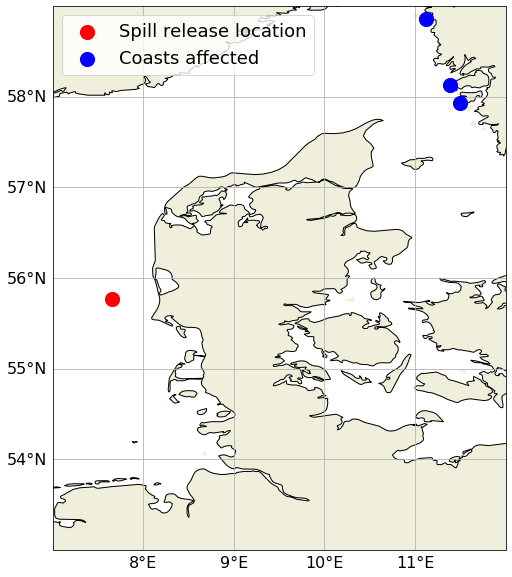

In [19]:
plt.figure(figsize=(12,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='10m')
ax1.add_feature(cartopy.feature.LAND, facecolor=cartopy.feature.COLORS['land'])

ax1.scatter(lon_ref, lat_ref, c='r', s=200, transform=ccrs.PlateCarree(), label = 'Spill release location', zorder=500) #marker='o'

ax1.scatter(lon_end_1, lat_end_1, c='b', s=200, transform=ccrs.PlateCarree(), label = 'Coasts affected', zorder=500) #marker='o'
ax1.scatter(lon_end_2, lat_end_2, c='b', s=200, transform=ccrs.PlateCarree(), zorder=500) #marker='o'
ax1.scatter(lon_end_3, lat_end_3, c='b', s=200, transform=ccrs.PlateCarree(), zorder=500) #marker='o'

ax1.set_xlim([7, 12])
ax1.set_ylim([53, 59])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16} #, 'color': 'gray'}
gl.ylabel_style = {'size': 16} #{'color': 'red', 'weight': 'bold'}
ax1.legend(fontsize=18)

plt.savefig('OilSpills_NATL_data_start_end.png', dpi=300)


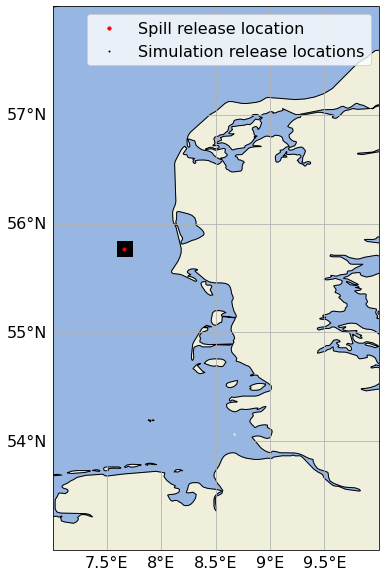

In [23]:
plt.figure(figsize=(12,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='10m')
ax1.add_feature(cartopy.feature.LAND, facecolor=cartopy.feature.COLORS['land'])
ax1.add_feature(cartopy.feature.OCEAN)

ax1.scatter(lon_ref, lat_ref, c='r', s=10, transform=ccrs.PlateCarree(), label = 'Spill release location', zorder=500) #marker='o'

ax1.scatter(ds['lon'][:,0], ds['lat'][:,0], c='k', s=1, transform=ccrs.PlateCarree(), label = 'Simulation release locations') #marker='o'
ax1.set_xlim([7, 10])
ax1.set_ylim([53, 58])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16} #, 'color': 'gray'}
gl.ylabel_style = {'size': 16} #{'color': 'red', 'weight': 'bold'}
ax1.legend(fontsize=16)

# plt.savefig('OilSpills_NATL_v2_01.png', dpi=300)


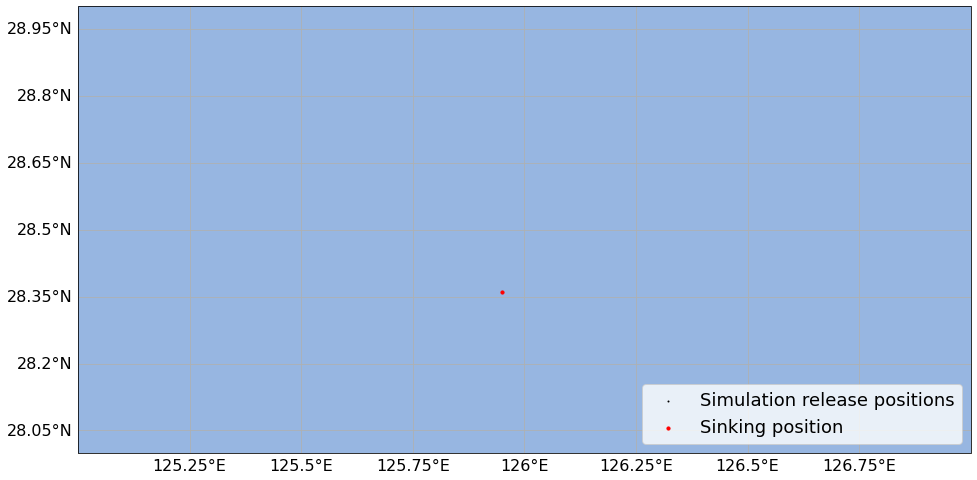

In [32]:
plt.figure(figsize=(16,16)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
# ax1.coastlines(resolution='10m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
# ax1.plot(ds['lon'].T, ds['lat'].T, transform=ccrs.PlateCarree()) #marker='o'
ax1.add_feature(cartopy.feature.OCEAN)
ax1.scatter(ds['lon'][:,0], ds['lat'][:,0], c='k', s=1, transform=ccrs.PlateCarree(), label = 'Simulation release positions') #marker='o'
ax1.scatter(125.95, 28.36, c='r', s=10, transform=ccrs.PlateCarree(), label='Sinking position')
ax1.set_xlim([125, 127])
ax1.set_ylim([28., 29])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax1.legend(loc=4, fontsize=18)
gl.xlabel_style = {'size': 16} #, 'color': 'gray'}
gl.ylabel_style = {'size': 16} #{'color': 'red', 'weight': 'bold'}
ax1.add_feature(cartopy.feature.OCEAN)

https://stackoverflow.com/questions/55303911/add-polygon-box-to-cartopy-python

In [33]:
import cartopy
import cartopy.feature as cpf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from shapely import geometry
from collections import namedtuple
from shapely.geometry.polygon import LinearRing

In [34]:
Region = namedtuple('Region',field_names=['region_name','lonmin','lonmax','latmin','latmax'])

region = Region(
    region_name="all_region",
    lonmin = 120.,
    lonmax = 135.,
    latmin = 25.,
    latmax = 32.,
)

sub_region =  Region(
        region_name="sub_region",
        lonmin=125,
        lonmax=127,
        latmin=28.,
        latmax=29.
)



In [35]:
def add_sub_region_box(ax, subregion):
    """ """
    geom = geometry.box(minx=subregion.lonmin,maxx=subregion.lonmax,miny=subregion.latmin,maxy=subregion.latmax)
    ax.add_geometries([geom], crs=cartopy.crs.PlateCarree(), alpha=0.3)

    return ax

<GeoAxesSubplot:>

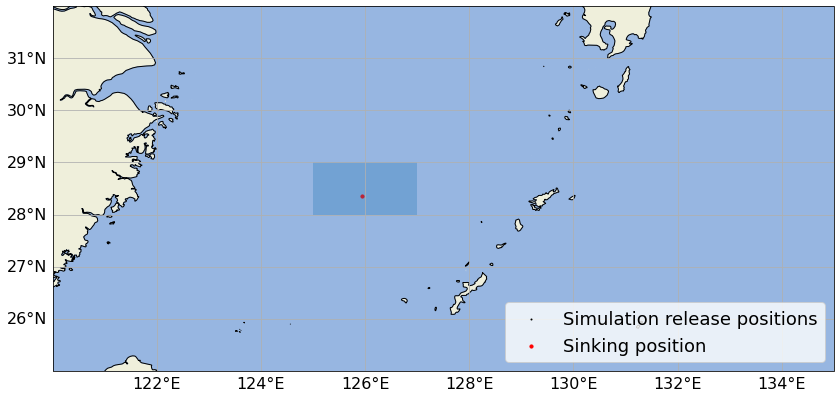

In [36]:
plt.figure(figsize=(14,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='10m')

ax1.add_feature(cartopy.feature.LAND, facecolor=cartopy.feature.COLORS['land'])
ax1.add_feature(cartopy.feature.BORDERS)#, linestyle=':')
ax1.add_feature(cartopy.feature.OCEAN)
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
# ax1.plot(ds['lon'].T, ds['lat'].T, transform=ccrs.PlateCarree()) #marker='o'
ax1.scatter(ds['lon'][:,0], ds['lat'][:,0], c='k', s=1, transform=ccrs.PlateCarree(), label = 'Simulation release positions') #marker='o'
ax1.scatter(125.95, 28.36, c='r', s=10, transform=ccrs.PlateCarree(), label='Sinking position')
ax1.set_xlim([120, 135])
ax1.set_ylim([25, 32])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax1.legend(loc=4, fontsize=18)
gl.xlabel_style = {'size': 16} #, 'color': 'gray'}
gl.ylabel_style = {'size': 16} #{'color': 'red', 'weight': 'bold'}

add_sub_region_box(ax1, sub_region)


/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


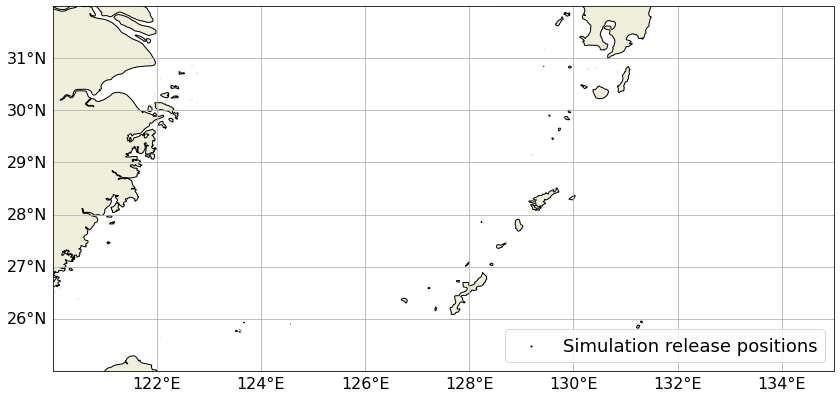

In [37]:
plt.figure(figsize=(14,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='10m')

ax1.add_feature(cartopy.feature.LAND, facecolor=cartopy.feature.COLORS['land'])
ax1.add_feature(cartopy.feature.BORDERS)#, linestyle=':')
# ax1.add_feature(cartopy.feature.OCEAN)
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
# ax1.plot(ds['lon'].T, ds['lat'].T, transform=ccrs.PlateCarree()) #marker='o'
ax1.plot(ds['lon'].T, ds['lat'].T, transform=ccrs.PlateCarree()) #marker='o'
ax1.scatter(ds['lon'][:,0], ds['lat'][:,0], c='k', s=1, transform=ccrs.PlateCarree(), label = 'Simulation release positions', zorder=500) #marker='o'
ax1.set_xlim([120, 135])
ax1.set_ylim([25, 32])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax1.legend(loc=4, fontsize=18)
gl.xlabel_style = {'size': 16} #, 'color': 'gray'}
gl.ylabel_style = {'size': 16} #{'color': 'red', 'weight': 'bold'}
